# Pop or rock classifier notebook
This notebook will help you preprocess a dataset to work on the Peltarion Platform. Both to make sure it is well balanced and that it only includes the info you need (in this case pop & rock lyrics).
One more thing, you should read our [requirements](https://peltarion.com/knowledge-center/documentation/datasets-view/import-files-and-data-sources-to-the-platform) on input datasets.


## Download the dataset

First things first, you need to download the dataset [Kaggle](https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics) you are going to use. In this dataset, there are around 380,000+ lyrics from a lot of different artists and genres, all arranged by year. 

When the download is done, extract the dataset into the same directory as this notebook.

## Setup environment
To prepare the data, you need to import some Python packages. 

* `pandas` lets us work with the data in an easy way 
* `matplotlib` is used to create pretty plots.

In [1]:
! pip install matplotlib pandas
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')

Looking in indexes: https://nexus.bahnhof.plattan.fi/repository/pypi/simple, https://pypi.org/simple
You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Preprocess the dataset csv to fit the Peltarion Platform
The first thing we will do is load the data into a `pandas` dataframe and look at it.

In [2]:
plain_df = pd.read_csv('lyrics.csv')

#Show the dataset
display(plain_df.head())

#Check if anything is missing
display(plain_df.isnull().any())

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


index     False
song       True
year      False
artist    False
genre     False
lyrics     True
dtype: bool

### Remove all rows with missing values
You can see that the `song` and `lyrics` fields are missing for some rows. Training a model requires all fields to be populated, and so we simply remove all rows with missing entries. 

Removing rows works well with this large dataset, but for smaller datasets where you don't want to remove data, you could instead replace the missing values, e.g., with average value or the most frequent value. It all depends on your dataset.

In [3]:
# remove all rows that are not fully populated
removed_na_df = plain_df.dropna()
removed_na_df.isnull().any()

index     False
song      False
year      False
artist    False
genre     False
lyrics    False
dtype: bool

### Keep only pop and rock genres
Having cleaned the data, we can now focus on the task at hand: classifying between pop or rock. 
To train a classifier for this, we do not need lyrics from any other genre and can remove all other lyric genres.

#### Shuffle data
In addition, we will shuffle the data around to make sure that lyrics from both the pop and the rock genre are mixed together. This is important when training a model.

In [4]:
genre_and_lyrics = removed_na_df[['genre', 'lyrics']]
groups = genre_and_lyrics.groupby('genre')
unshuffled_data = pd.concat((groups.get_group('Pop'), 
                             groups.get_group('Rock')))
data = unshuffled_data.sample(n=len(unshuffled_data))
display(data.head())

,genre,lyrics
233809,Pop,Unstoppable\nI got the fire in my heart\nI'm n...
11684,Rock,I got a friend\nHe lives down in old Albuquerq...
295743,Rock,Hello...seems I forgot your name again. Do you...
307505,Pop,I never thought that\nYou would be the one to ...
35323,Rock,"Listen when I say, when I say it's real\nReal ..."


## Sequence length
The BERT model requires a pre-defined `sequence length` between **3-512** to work. However, song lyrics can be of any length, so we need to decide what this sequence length should be.

A larger `sequence length` lets the model capture more information, typically giving better performance,
but it also increases the training time quite a lot. Hence, we want to set a `sequence length` to a value that is large enough to capture most lyrics, but not any larger.

Running the script below it, looks like we can compromise and select a `sequence length` of **400** to make training time a bit shorter while only truncating about **3%** of the lyrics.

The `sequence length` is entered in the Datasets view in the Peltarion Platform. 

**Easy experimenting on the platform**

Testing different settings is really easy on the platform. You should try to run the same model with different `sequence lengths` to see how much a lower or a higher value impacts on the accuracy and training time.

A max length of 400 truncates 0.027 of the lyrics.


Matplotlib is building the font cache using fc-list. This may take a moment.


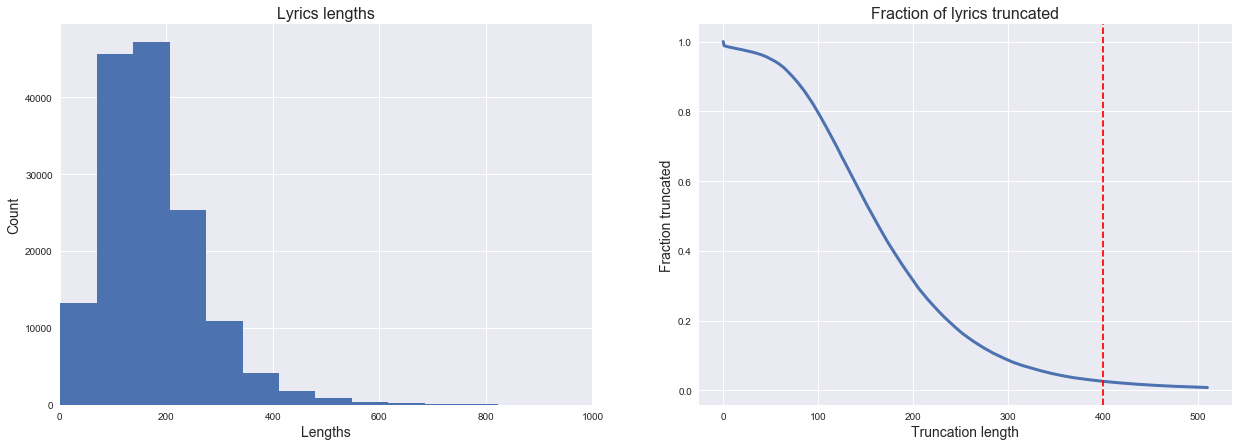

In [5]:
lens = data.lyrics.apply(lambda x: len(x.split(' ')))
bert_max_len = 512
max_len = 400

def fraq_trunced(lengths, max_len):
    return 1 - len(lengths[lengths < max_len]) / len(lengths)

truncs = [fraq_trunced(lens, x) for x in range(1, bert_max_len)]

fig, (len_ax, trunc_ax) = plt.subplots(1, 2, figsize=(21, 7))
len_ax.hist(lens, bins=80)
len_ax.set_xlim((0, 1000))
len_ax.set_title('Lyrics lengths', fontsize=16)
len_ax.set_xlabel('Lengths', fontsize=14)
len_ax.set_ylabel('Count', fontsize=14)

trunc_ax.plot(range(len(truncs)), truncs, lw=3)
trunc_ax.set_title('Fraction of lyrics truncated', fontsize=16)
trunc_ax.set_xlabel('Truncation length', fontsize=14)
trunc_ax.set_ylabel('Fraction truncated', fontsize=14)
trunc_ax.axvline(max_len, linestyle='--', color='red')
print(f'A max length of {max_len} truncates {fraq_trunced(lens, max_len):.3f} of the lyrics.')

# Class balance
During model training, it is important that the model is presented with examples from all classes. Additionally, if one class if much more common than another, the model will see this class more often and consequently learn to recognize this class much better than the other. This is, of course, a bad thing, so we want to make sure the data is *balanced* between all classes before training on it.

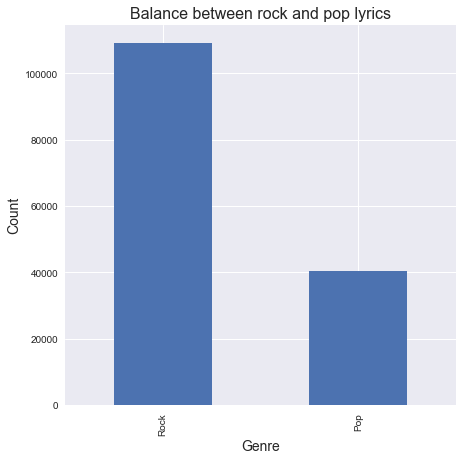

In [6]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title('Balance between rock and pop lyrics', fontsize=16)
ax.set_xlabel('Genre', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
data.genre.value_counts().plot(kind='bar', ax=ax)

# Balance classes

Looking at the balance between the rock and pop genre shows that there are about three times as many rock lyrics in the dataset. To deal with this, we are going to *downsample* the rock class. That is, we are going to randomly throw away rock lyrics until the two classes are in balance.

There are 68769 more rock lyrics than pop lyrics. We will remove these 68769 rock lyrics to make the dataset balanced.


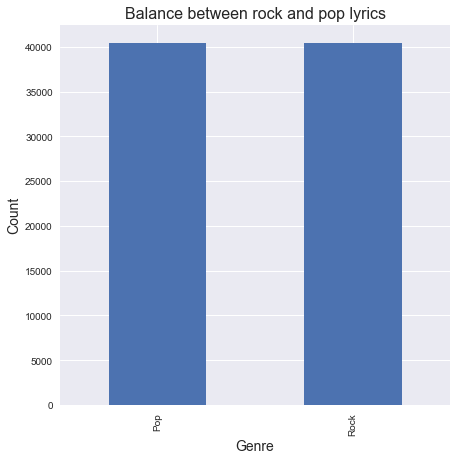

In [11]:
pop = data[data.genre == 'Pop']
rock = data[data.genre == 'Rock']
diff = len(rock) - len(pop)
print(f'There are {diff} more rock lyrics than pop lyrics. We will remove these {diff} rock lyrics to make the dataset balanced.')

downsampled_data = pd.concat((pop, rock.sample(n=len(pop))), ignore_index=True)
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title('Balance between rock and pop lyrics', fontsize=16)
ax.set_xlabel('Genre', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
downsampled_data.genre.value_counts().plot(kind='bar', ax=ax)

# Create output csv
That concludes the data preprocessing. Let's save the dataset, so that it can be imported and used on the Peltarion Platform!

In [12]:
downsampled_data.to_csv('balanced_downsampled_pop_rock_lyrics.csv')